In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
pers_experiments = "(hostname == 'scyper21' or hostname == 'scyper22')"

libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "sortledton", "stinger7-ref", "teseo-lcc.12"]
#libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "sortledton", "teseo-lcc.12", "llama8-ref"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

threads_filter = [1, 2, 4, 8, 14, 28, 42, 56]
threads_filter = " | ".join(map(lambda l: "num_threads == " + str(l), threads_filter))

edges_per_graph = pd.DataFrame({
    "graph": ["com-friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

scaling_graphs="graph == 'graph500-24'"

data = common.import_gfe("View_Inserts").query(pers_experiments).copy() # data from the experiments
data = data.query(scaling_graphs)
data = data.query(threads_filter)
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by
data = data.merge(edges_per_graph, on="graph")
data["edges_per_second"] = data["edges"] / data["completion_time_secs"]
data = data.query(libraries_filter)

data = data.merge(data.query("num_threads == 1"), on=["compiler", "graph", "library"], suffixes=("", "_y"), how="outer")
data["base_time"] = data["edges_per_second_y"]
data["speedup"] = data["edges_per_second"] / data["base_time"]

In [3]:
data_grouped = data.groupby(["compiler_family", "graph", "library", "build_frequency", "num_threads"]) \
    .agg(min_eps = ("edges_per_second", "min"), max_eps=("edges_per_second", "max"),speedup=("speedup", "median"), edges_per_second=("edges_per_second", "median"), base=("base_time", "median"), count=("edges_per_second", "count"))
#data = data.unstack("algorithm")[("completion_time")]
data_grouped.index.set_names("compiler", level=0, inplace=True)
data_grouped

min_eps  \
compiler graph       library                build_frequency num_threads                 
gcc      graph500-24 g1_v6-ref-ignore-build 0 days 00:00:00 1            1.180921e+06   
                                                            2            1.383266e+06   
                                                            4            2.418809e+06   
                                                            8            2.889757e+06   
                                                            14           3.386599e+06   
                                                            28           3.424617e+06   
                                                            42           2.800239e+06   
                                                            56           1.992246e+06   
                     livegraph3_ro          0 days 00:00:00 1            4.483728e+04   
                                                            2            8.824655e+04   
                                                            4            1.656193e+05   
                                                            8            2.609173e+05   
                                                            14           3.280355e+05   
                                                            28           3.447297e+05   
                                                            42           3.424092e+05   
                                                            56           3.102290e+05   
                     llama8-ref             0 days 00:00:10 1            1.295408e+04   
                                                            2            4.053094e+04   
                                                            4            9.773502e+04   
                                                            8            1.979218e+05   
                                                            14           2.676724e+05   
                                                            28           2.811366e+05   
                                                            42           2.678139e+05   
                                                            56           2.556201e+05   
                     sortledton             0 days 00:00:00 1            1.875911e+05   
                                                            2            3.615838e+05   
                                                            4            5.967215e+05   
                                                            8            1.149547e+06   
                                                            14           1.912416e+06   
                                                            28           3.093585e+06   
                                                            42           3.815671e+06   
                                                            56           3.258659e+06   
                     stinger7-ref           0 days 00:00:00 1            5.579172e+03   
                                                            2            1.082676e+04   
                                                            4            1.821053e+04   
                                                            8            3.367671e+04   
                                                            14           5.341048e+04   
                                                            28           8.726013e+04   
                                                            42           9.750461e+04   
                                                            56           1.058600e+05   
                     teseo-lcc.12           0 days 00:00:00 1            1.970363e+05   
                                                            2            3.518874e+05   
                                                            4            6.595905e+05   
                                                            8            

In [6]:
stinger = pd.concat( [
    data_grouped.loc[("gcc", slice(None), "stinger7-ref", slice(None), slice(None))].droplevel([1])
], names=["library", "graph", "threads"], keys=["stinger"])
llama = pd.concat( [
   data_grouped.loc[("gcc", slice(None), "llama8-ref", "00:00:10", slice(None))].droplevel([]) # dynamic scheduling in OpenMP
], names=["library","graph", "threads"], keys=["llama"] )
graphone = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "g1_v6-ref-ignore-build", slice(None), slice(None))].droplevel([1])
],names=["library", "graph", "threads"], keys=["graphone"] )
livegraph = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "livegraph3_ro", slice(None), slice(None))].droplevel([1])
], names=["library", "graph", "threads"], keys=["livegraph"] )
teseo = data_grouped.loc[("gcc", slice(None), "teseo-lcc.12", slice(None), slice(None))].droplevel([1])
teseo = pd.concat([ pd.concat([teseo], axis=1 ) ], names=["library", "graph", "threads"], keys=["teseo"])
sortledton1 = data_grouped.loc[("gcc", slice(None), "sortledton", slice(None), slice(None))].droplevel([1])
sortledton = pd.concat([ pd.concat([sortledton1], axis=1 ) ], names=["library", "graph", "threads"], keys=["sortledton"])

all_libs = pd.concat([stinger,llama,graphone,livegraph,teseo,sortledton])
all_libs = all_libs.drop("count", axis=1)
all_libs = all_libs.drop("min_eps", axis=1)
all_libs = all_libs.drop("max_eps", axis=1)
all_libs = all_libs.drop("edges_per_second", axis=1)
all_libs = all_libs.drop("base", axis=1)

#all_libs = all_libs.reindex(index=["graph", "library"])
#all_libs = all_libs.swaplevel(0,1)
#all_libs = all_libs.sort_index()
all_libs = all_libs.pivot_table(values="speedup", columns="library", index="threads")

all_libs["linear"] = [1, 2, 4, 8, 14, 28, 42, 56] 

#column_order = ["sortledton", "teseo", "graphone", "stinger", "llama", "livegraph"]
#all_libs = all_libs[column_order]

all_libs

library,graphone,livegraph,llama,sortledton,stinger,teseo,linear
threads,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
2,1.171345,1.968151,3.128816,1.927510,1.940567,1.785901,2
4,2.048240,3.693785,7.544728,3.180969,3.264021,3.347558,4
8,2.447037,5.819205,15.278725,6.127936,6.036149,5.717283,8
14,2.867762,7.316133,20.663171,10.194594,9.573191,8.419187,14
28,2.899955,7.688462,21.702548,16.491106,15.640337,12.615858,28
42,2.371234,7.636708,20.674097,20.340357,17.476538,14.758438,42
56,1.687028,6.918998,19.732783,22.119626,19.168317,15.556984,56


<AxesSubplot:xlabel='Parallelism degree', ylabel='Speedup'>

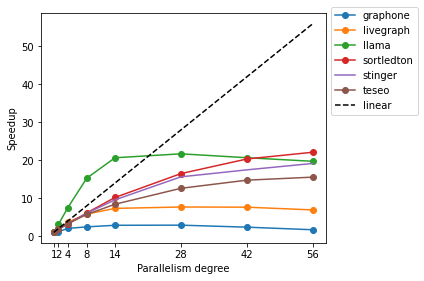

In [7]:
path = os.environ["HOME"] + "/workspace/sortledton/src/figures/insertions_speedup.png"

style_d = {
    "graphone": "-o",
    "livegraph": "-o",
    "sortledton": "-o",
    "teseo": "-o",
    "llama": "-o",
    "linear": "--k"
}

p = all_libs.plot.line(style=style_d)
p.legend(bbox_to_anchor=(1.0, 1.05))
plt.ylabel("Speedup")
plt.xlabel("Parallelism degree")
plt.xticks([1, 2, 4, 8, 14, 28, 42, 56])
plt.tight_layout()
plt.savefig(path)

p

edges_per_second    28426.525662
count                   1.000000
dtype: float64